<center>
    <img src="https://digip.unibg.it/sites/dip3/files/logo-dip-it.svg">
    <h1><b>Crash course in Python</b> - AA 2025/2026</h1>
    <h2>Lezione 3 - Caso di studio 📚​</h2>
    <h3>A cura di <a href="https://github.com/lamferzon?tab=repositories">Lorenzo Leoni</a></h3>
</center>

# Presentazione del dataset

Questo dataset fornisce una rappresentazione ampia e realistica dei vari fattori che contribuiscono alla prestazione degli studenti negli esami. Contiene 20.000 record, ognuno dei quali descrive il comportamento accademico degli studenti, le loro abitudini di studio, le routine di vita quotidiana e le condizioni degli esami. Queste variabili aiutano a comprendere come diversi aspetti della vita quotidiana e dell'ambiente di apprendimento degli studenti influenzino i risultati degli esami.

## Obiettivo

Costruire un modello predittivo in grado di prevedere il punteggio di un esame (votazione da 0 a 100) in base alle altre variabili presenti nel dataset.

## Sorgente

Il dataset è disponibile su **Kaggle**, un sito web di condivisione di dataset e competizioni di data science, al seguente [link](https://www.kaggle.com/datasets/kundanbedmutha/exam-score-prediction-dataset/data).

# Premessa

In questa lezione, viene utilizzata la libreria [**Polars**](https://docs.pola.rs/) per la manipolazione dei dati sotto forma di DataFrame. Si differenzia dalla più comune libreria **Pandas** per diversi aspetti:

| Caratteristica                    | Pandas                                              | Polars                                                     |
|-----------------------------------|:---------------------------------------------------:|:----------------------------------------------------------:|
| **Linguaggio di implementazione** | Python puro                                         | Rust (con API per Python)                                  |
| **Tipologia**                     | Basto su righe, ottimizzato per cicli for           | Basato su colonne, ottimizzato per operazioni vettoriali   |
| **Performance**                   | Più lento per grandi dataset                        | Molto più veloce grazie all'implementazione in Rust        |
| **Gestione della memoria**        | Non ottimizzata per dataset molto grandi            | Ottimizzata per dataset di grandi dimensioni               |
| **Parallellismo**                 | Non supporta il multithreading nativamente          | Supporta il multithreading nativamente                     |
| **API**                           | API Python-like, molto diffusa                      | API simile a Pandas, ma con alcune differenze              |
| **Supporto per query SQL**        | Limitato                                            | Supporto nativo per query SQL-like                         |
| **Compatibilità**                 | Ampiamente utilizzato, supportato da molte librerie | Meno diffuso, ma in crescita                               |
| **Ecosistema**                    | Maturo, integrato con molte librerie Python         | In crescita, ma meno integrato rispetto a Pandas           |
| **Utilizzo principale**           | Analisi di dati di piccole/medie dimensioni         | Analisi di dati di grandi dimensioni o ad alte performance |

# Importazione delle librerie

In [62]:
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from tabulate import tabulate
from statsmodels.formula.api import ols
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Importazione dei dati

In [14]:
# importazione del dataset
data = pl.read_csv(
    source = "student_data.csv"
)

# correzione dei tipi di dato
categorical_columns = [
    "gender",
    "course",
    "sleep_quality",
    "study_method",
    "exam_difficulty"
]
numeric_columns = [
    "age",
    "study_hours",
    "class_attendance",
    "sleep_hours",
    "exam_score"
]
data = data.drop(
    "student_id",
    "facility_rating"
).with_columns(
    pl.when(
        pl.col("internet_access") == "yes"
    ).then(
        True
    ).otherwise(
        False
    ).alias("internet_access")
).with_columns(
    [
        pl.col(col).cast(pl.Categorical) for col in categorical_columns
    ]
)

# visualizzazione delle prime 10 righe del dataset
data.head(10)

age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,exam_difficulty,exam_score
i64,cat,cat,f64,f64,bool,f64,cat,cat,cat,f64
17,"""male""","""diploma""",2.78,92.9,true,7.4,"""poor""","""coaching""","""hard""",58.9
23,"""other""","""bca""",3.37,64.8,true,4.6,"""average""","""online videos""","""moderate""",54.8
22,"""male""","""b.sc""",7.88,76.8,true,8.5,"""poor""","""coaching""","""moderate""",90.3
20,"""other""","""diploma""",0.67,48.4,true,5.8,"""average""","""online videos""","""moderate""",29.7
20,"""female""","""diploma""",0.89,71.6,true,9.8,"""poor""","""coaching""","""moderate""",43.7
23,"""male""","""b.tech""",3.48,65.4,true,4.2,"""good""","""mixed""","""moderate""",58.2
17,"""female""","""b.tech""",1.35,69.0,true,7.4,"""average""","""online videos""","""hard""",53.7
22,"""male""","""b.sc""",5.48,51.1,true,8.2,"""poor""","""self-study""","""moderate""",47.3
18,"""other""","""bca""",2.89,92.0,true,6.6,"""poor""","""self-study""","""easy""",44.9


# EDA (Exploratory Data Analysis)

## Distribuzione delle variabili numeriche e correlogramma

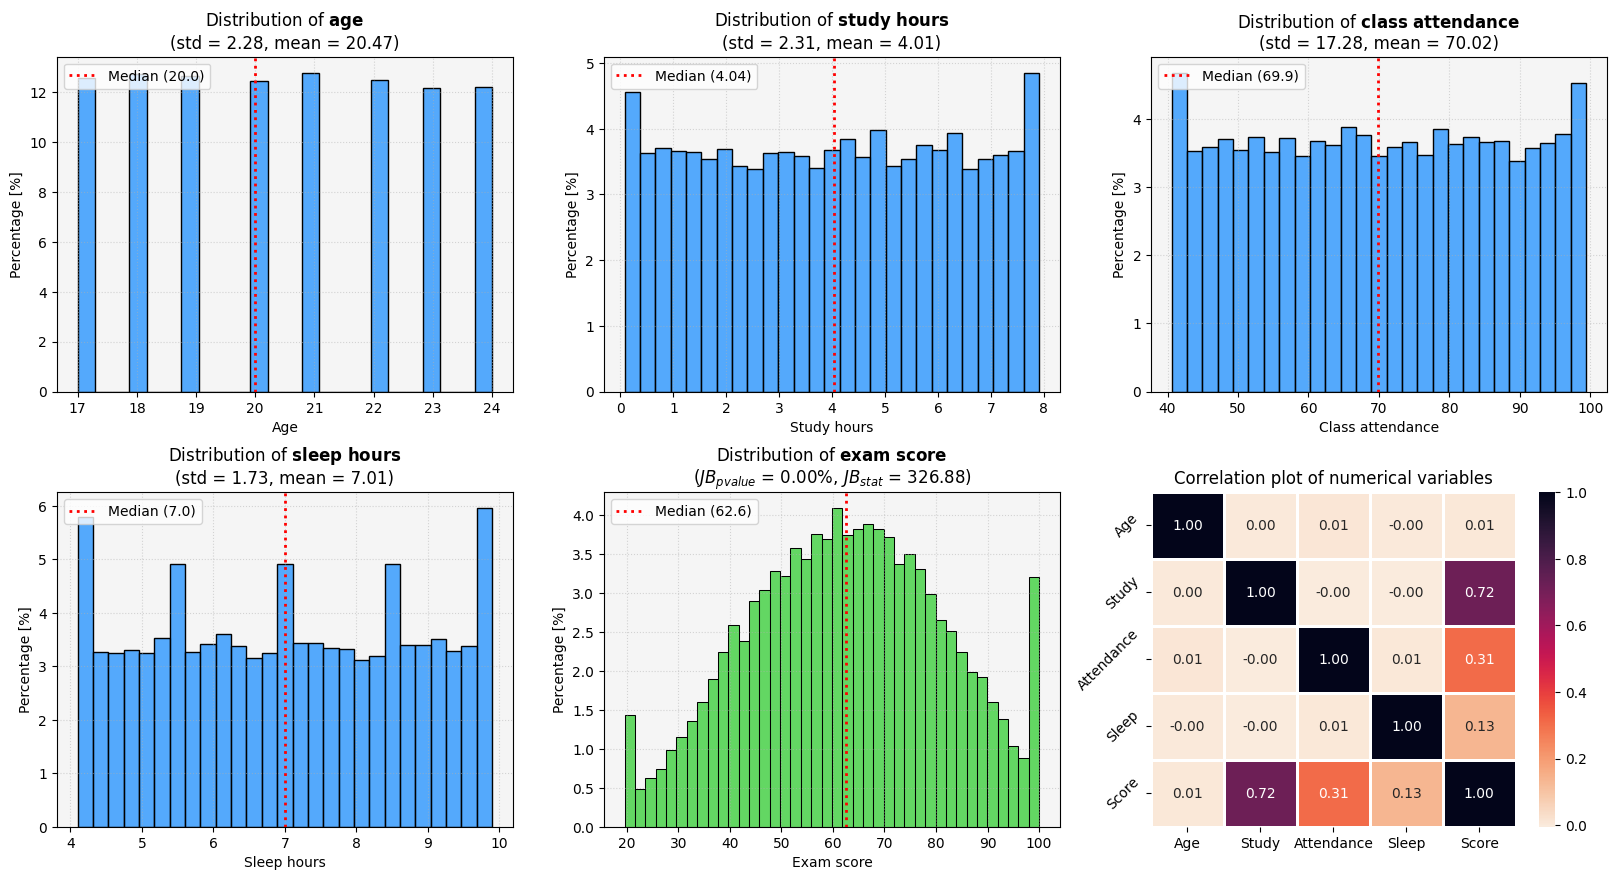

In [15]:
# layout
ncols = 3
nrows = 2
fig, axes = plt.subplots(
    nrows = nrows,
    ncols = ncols,
    figsize=(20, nrows * 5)
)
fig.subplots_adjust(
    hspace = .3,
    wspace = .2
)
axes = axes.flatten()

for i, variable_i in enumerate(numeric_columns):

    sns.histplot(
        data = data.to_pandas(),
        x = variable_i,
        stat = "percent",
        color = "limegreen" if variable_i == "exam_score" else "dodgerblue",
        ax = axes[i]
    )
    median_i = data[variable_i].median()
    axes[i].axvline(
        median_i,
        color = "red",
        ls = ":",
        lw = 2,
        label = f"Median ({median_i})"
    )
    axes[i].set(
        xlabel = variable_i.capitalize().replace("_", " "),
        ylabel = "Percentage [%]",
        facecolor = "whitesmoke"
    )
    axes[i].grid(
        ls = ":",
        alpha = .5
    )
    axes[i].legend(
        loc = "upper left"
    )

    # test di normalità di Jarque-Bera per exam_score
    if variable_i == "exam_score":
        statistic, p_value = stats.jarque_bera(data[variable_i].to_list())
        axes[i].set_title(
            f"Distribution of $\\mathbf{{{variable_i.replace('_', ' \\ ')}}}$" +
            f"\n($JB_{{pvalue}}$ = {p_value*100:.2f}%, $JB_{{stat}}$ = {statistic:.2f})",
            fontsize = 12
        )
    else:
        axes[i].set_title(
            f"Distribution of $\\mathbf{{{variable_i.replace('_', ' \\ ')}}}$" +
            f"\n(std = {data[variable_i].std():.2f}, mean = {data[variable_i].mean():.2f})",
            fontsize = 12
        )

# correlogramma
corr = data[numeric_columns].rename(
    {
        "age": "Age",
        "study_hours": "Study",
        "class_attendance": "Attendance",
        "sleep_hours": "Sleep",
        "exam_score": "Score"
    }
).to_pandas().corr()
sns.heatmap(
    data = corr,
    annot = True,
    fmt = ".2f",
    cmap = "rocket_r",
    linewidths = 1,
    ax = axes[5]
)
axes[5].tick_params(
    "y",
    rotation = 45
)
axes[5].set_title(
    "Correlation plot of numerical variables",
    size = 12
);

## Legami tra le variabili categoriche e la variabile target

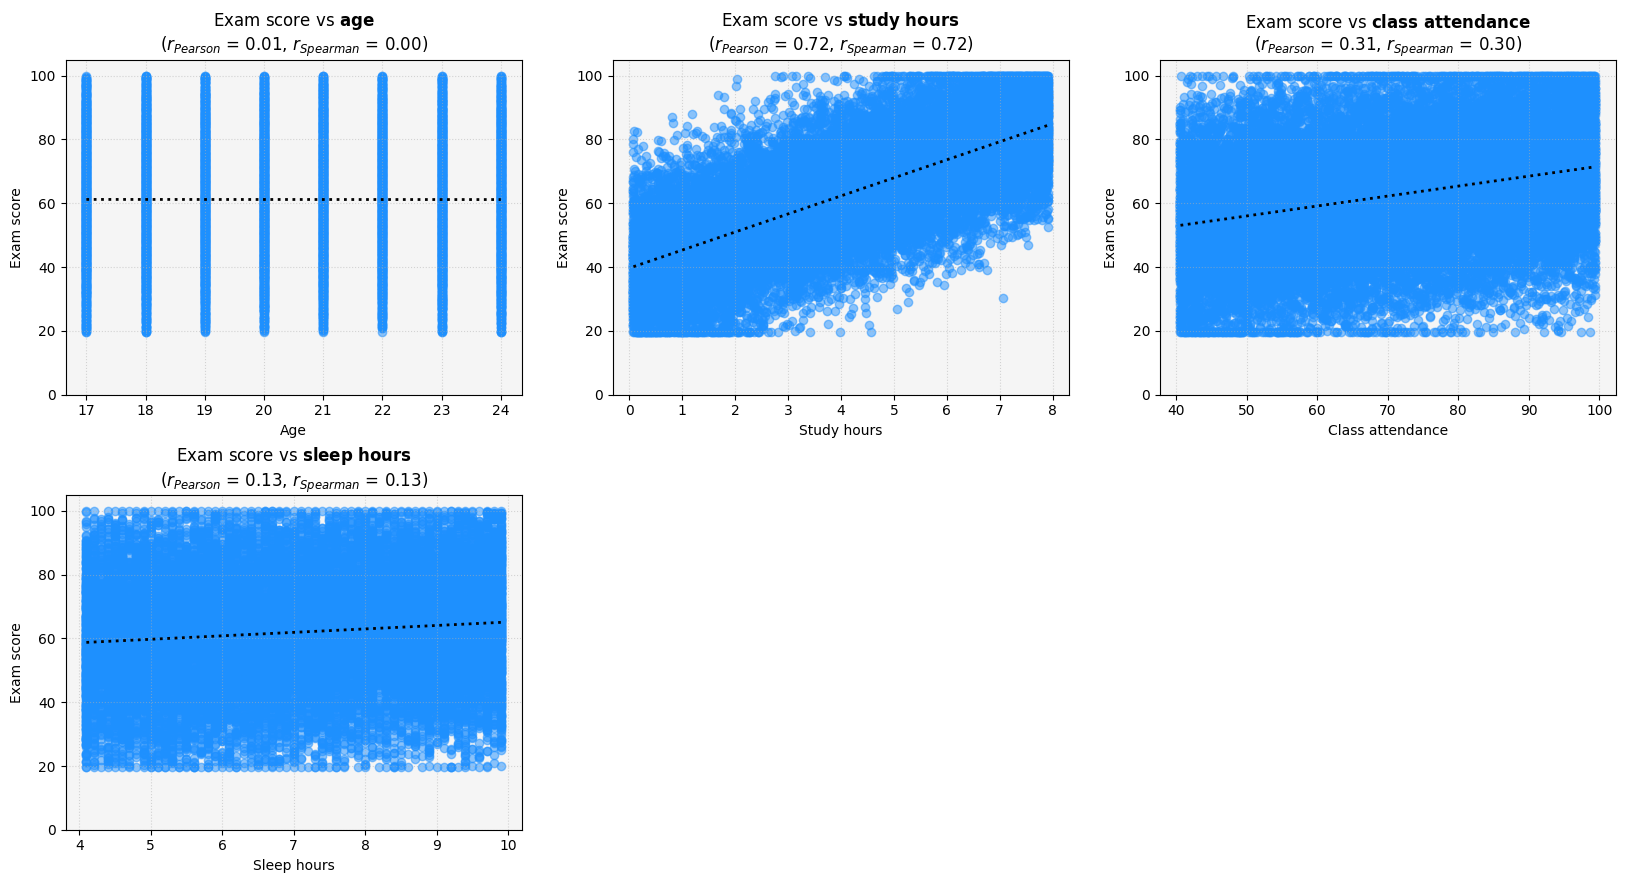

In [16]:
# layout
ncols = 3
nrows = 2
fig, axes = plt.subplots(
    nrows = nrows,
    ncols = ncols,
    figsize=(20, nrows * 5)
)
fig.subplots_adjust(
    hspace = .3,
    wspace = .2
)
axes = axes.flatten()

for i, variable_i in enumerate(numeric_columns[0:4]):
    
    sns.regplot(
        data = data.unique(
            subset = [variable_i, "exam_score"]
        ),
        x = variable_i,
        y = "exam_score",
        scatter_kws = {
            "color": "dodgerblue",
            "alpha": .5
        },
        line_kws = {
            "color": "black",
            "ls": ":",
            "lw": 2
        },
        ci = None,
        ax = axes[i]
    )
    axes[i].set(
        xlabel = variable_i.capitalize().replace("_", " "),
        ylim = (0, 105),
        ylabel = "Exam score",
        facecolor = "whitesmoke"
    )
    axes[i].grid(
        ls = ":",
        alpha = .5
    )

    # calcolo dei coefficienti di correlazione
    r_pearson = stats.pearsonr(data[variable_i].to_list(), data["exam_score"].to_list())
    r_spearman = stats.spearmanr(data[variable_i].to_list(), data["exam_score"].to_list())
    axes[i].set_title(
        f"Exam score vs $\\mathbf{{{variable_i.replace('_', ' \\ ')}}}$"
        + f"\n($r_{{Pearson}}$ = {r_pearson[0]:.2f}, $r_{{Spearman}}$ = {r_spearman.correlation:.2f})",
        fontsize = 12
    )

# rimozione delle figure vuote
for j in range(i + 1, nrows * ncols):
    fig.delaxes(axes[j])

## Distribuzione delle variabili categoriche

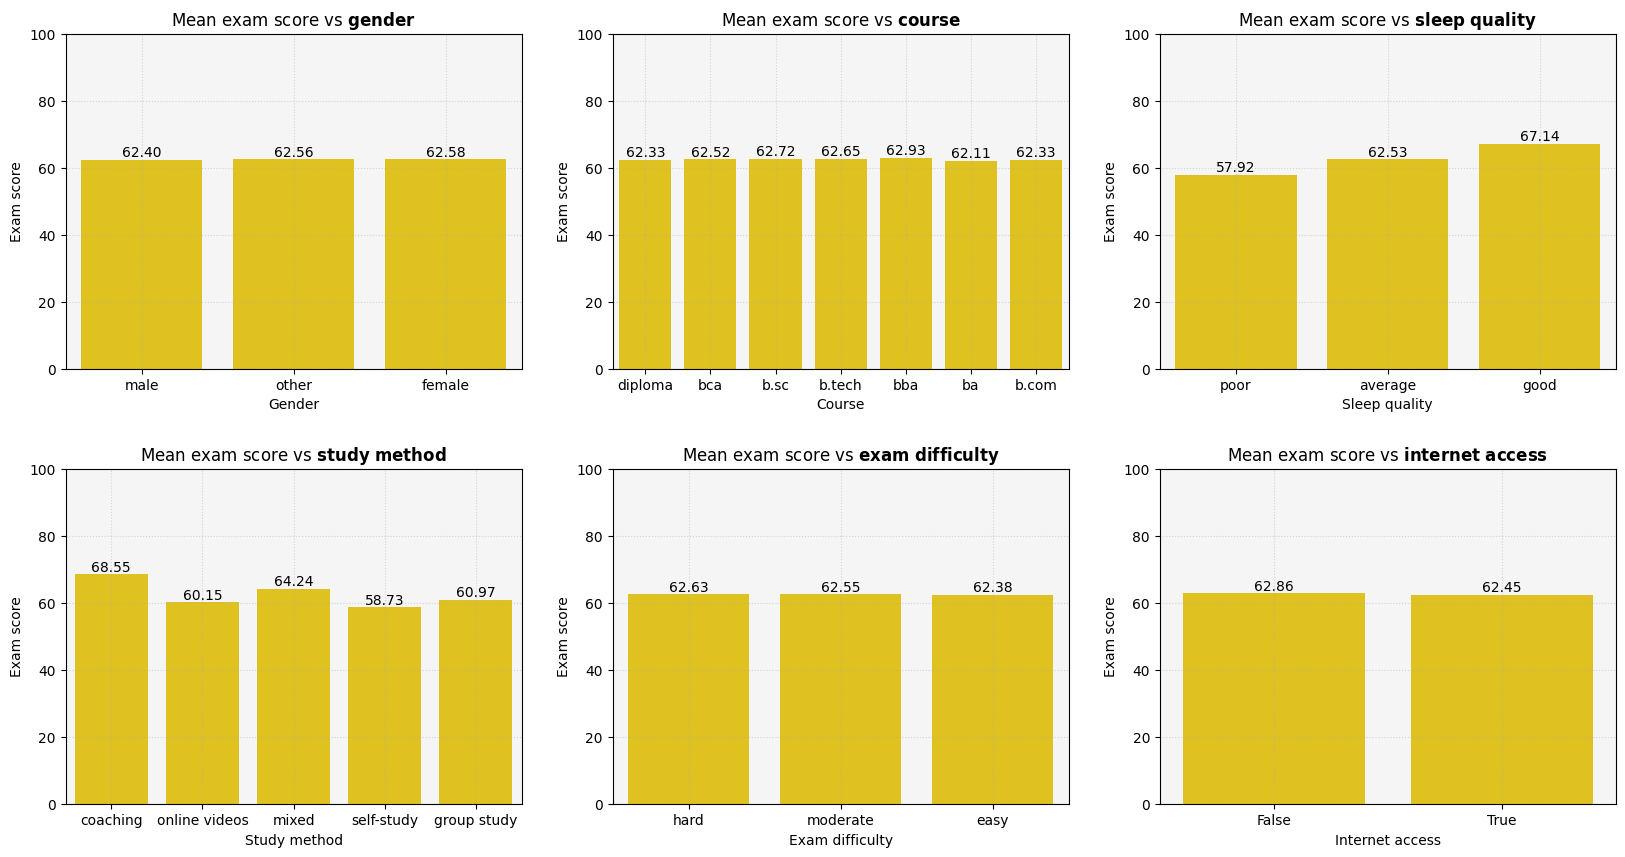

In [17]:
# layout
ncols = 3
nrows = 2
fig, axes = plt.subplots(
    nrows = nrows,
    ncols = ncols,
    figsize=(20, nrows * 5)
)
fig.subplots_adjust(
    hspace = .3,
    wspace = .2
)
axes = axes.flatten()

for i, variable_i in enumerate(categorical_columns + ["internet_access"]):

    sns.barplot(
        data = data.to_pandas(),
        x = variable_i,
        y = "exam_score",
        estimator = "mean",
        color = "gold",
        errorbar = None,
        ax = axes[i]
    )
    axes[i].set(
        xlabel = variable_i.capitalize().replace("_", " "),
        ylim = (0, 100),
        ylabel = "Exam score",
        facecolor = "whitesmoke"
    )
    axes[i].grid(
        ls = ":",
        alpha = .5
    )
    axes[i].bar_label(
        axes[i].containers[0],
        fontsize = 10,
        label_type = "edge",
        fmt = "%.2f"
    )
    axes[i].set_title(
        f"Mean exam score vs $\\mathbf{{{variable_i.replace('_', ' \\ ')}}}$",
        fontsize = 12
    )

# rimozione delle figure vuote
for j in range(i + 1, nrows * ncols):
    fig.delaxes(axes[j])

## Test ANOVA per selezionare le variabili categoriche più significative

In [18]:
ANOVA_results = []
for variable_i in categorical_columns + ["internet_access"]:

    ANOVA_table = sm.stats.anova_lm(
        ols(
            formula = f"exam_score ~ C({variable_i})",
            data = data.to_pandas()
        ).fit(),
        typ = 2
    )
    ANOVA_results.append(
        (variable_i, ANOVA_table.loc[f"C({variable_i})", "PR(>F)"])
    )

# visualizzazione dei risultati del test ANOVA
print(
    tabulate(
        tabular_data = ANOVA_results,
        headers = ["Categorical variable", "ANOVA p-value"],
        tablefmt = "pretty",
        colalign = ["center"] * 2
    )
)

+----------------------+-------------------------+
| Categorical variable |      ANOVA p-value      |
+----------------------+-------------------------+
|        gender        |   0.8264568162385278    |
|        course        |    0.718997584245856    |
|    sleep_quality     | 5.560727734015198e-176  |
|     study_method     | 3.1986673685643177e-152 |
|   exam_difficulty    |   0.7890206235239491    |
|   internet_access    |   0.2683975680182245    |
+----------------------+-------------------------+


# Stima del modello

In [19]:
# suddivisione del dataset in train e test set
train_data, test_data = train_test_split(
    data,
    test_size = .3,
    random_state = 42
)

# stima
mhat = ols(
    formula = "exam_score ~ age + study_hours + class_attendance + sleep_hours + C(sleep_quality) + C(study_method)",
    data = train_data.to_pandas()
).fit()
mhat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             exam_score   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     3296.
Date:                Tue, 09 Dec 2025   Prob (F-statistic):               0.00
Time:                        14:00:52   Log-Likelihood:                -52515.
No. Observations:               14000   AIC:                         1.051e+05
Df Residuals:                   13989   BIC:                         1.051e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            5.9322      0.963      6.158      0.000       4.044       7.820
C(sleep_quality)[T.poor]            -9.2219      0.213    -43.236      0.000      -9.640      -8.804
C(sleep_quality)[T.average]         -4.6003      0.213    -21.568      0.000      -5.018      -4.182
C(study_method)[T.online videos]     0.6646      0.272      2.442      0.015       0.131       1.198
C(study_method)[T.coaching]          9.6454      0.272     35.492      0.000       9.113      10.178
C(study_method)[T.mixed]             4.6570      0.275     16.932      0.000       4.118       5.196
C(study_method)[T.group study]       1.8431      0.274      6.727      0.000       1.306       2.380
age                                  0.0103      0.038      0.270      0.787      -0.065       0.085
study_hours                          5.8575      0.038    155.033      0.000       5.783       5.932
class_attendance                     0.3445      0.005     68.084      0.000       0.335       0.354
sleep_hours                          1.4252      0.050     28.343      0.000       1.327       1.524
==============================================================================
Omnibus:                        4.896   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.086   Jarque-Bera (JB):                4.627
Skew:                          -0.012   Prob(JB):                       0.0989
Kurtosis:                       2.914   Cond. No.                         837.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Con dati standardizzati

In [27]:
# standardizzazione dei dati
std_data = data.clone()
std_data[numeric_columns] = StandardScaler().fit_transform(
    data.select(numeric_columns)
)

# stima
mhat2 = ols(
    formula = "exam_score ~ age + study_hours + class_attendance + sleep_hours + C(sleep_quality) + C(study_method)",
    data = std_data.to_pandas()
).fit()
mhat2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             exam_score   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     4752.
Date:                Tue, 09 Dec 2025   Prob (F-statistic):               0.00
Time:                        14:01:18   Log-Likelihood:                -16209.
No. Observations:               20000   AIC:                         3.244e+04
Df Residuals:                   19989   BIC:                         3.253e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.0766      0.010      7.548      0.000       0.057       0.097
C(sleep_quality)[T.average]          0.2521      0.009     26.788      0.000       0.234       0.271
C(sleep_quality)[T.good]             0.4965      0.009     52.593      0.000       0.478       0.515
C(study_method)[T.online videos]    -0.4649      0.012    -38.443      0.000      -0.489      -0.441
C(study_method)[T.mixed]            -0.2544      0.012    -20.807      0.000      -0.278      -0.230
C(study_method)[T.self-study]       -0.4995      0.012    -41.326      0.000      -0.523      -0.476
C(study_method)[T.group study]      -0.4045      0.012    -33.145      0.000      -0.428      -0.381
age                                  0.0003      0.004      0.077      0.938      -0.007       0.008
study_hours                          0.7188      0.004    186.708      0.000       0.711       0.726
class_attendance                     0.3110      0.004     80.782      0.000       0.303       0.319
sleep_hours                          0.1314      0.004     34.122      0.000       0.124       0.139
==============================================================================
Omnibus:                        9.735   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                8.987
Skew:                          -0.015   Prob(JB):                       0.0112
Kurtosis:                       2.900   Cond. No.                         6.43
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Analisi dei residui

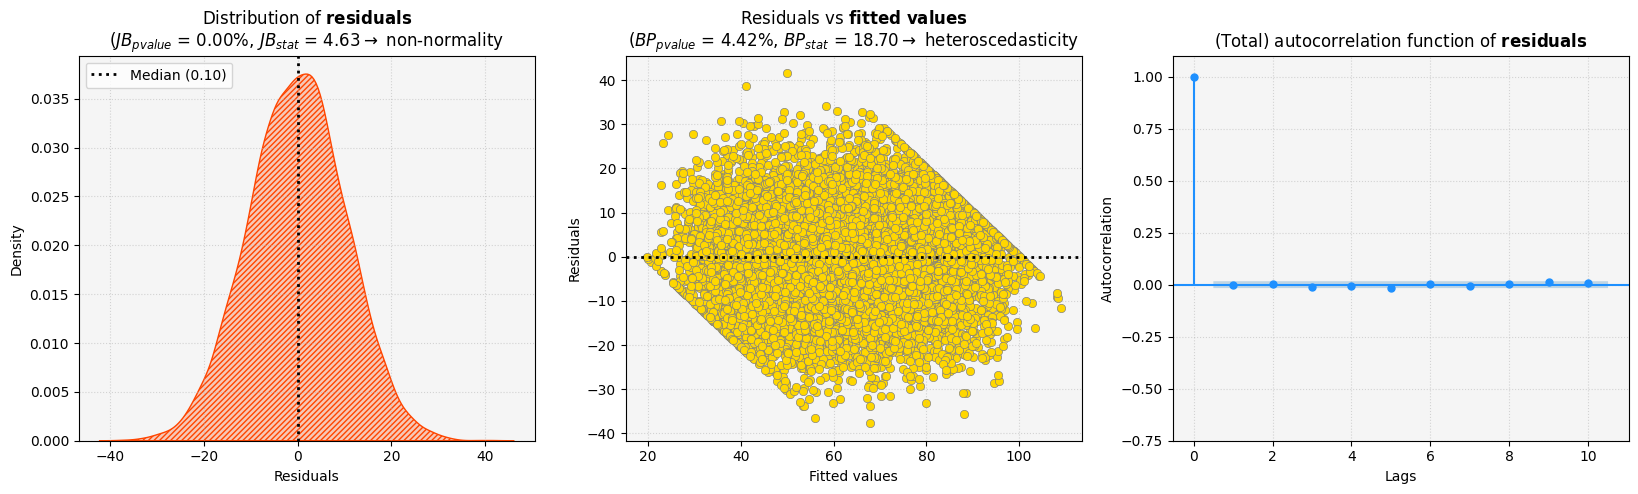

In [28]:
# layout
ncols = 3
nrows = 1
fig, axes = plt.subplots(
    nrows = nrows,
    ncols = ncols,
    figsize=(20, nrows * 5)
)


# distribuzione dei residui
sns.kdeplot(
    x = mhat.resid,
    color = "orangered",
    fill = True,
    hatch = "//////",
    ax = axes[0]
)
median_i = pl.Series(mhat.resid).median()
axes[0].axvline(
    median_i,
    color = "black",
    ls = ":",
    lw = 2,
    label = f"Median ({median_i:.2f})"
)
axes[0].set(
    xlabel = "Residuals",
    ylabel = "Density",
    facecolor = "whitesmoke"
)
axes[0].grid(
    ls = ":",
    alpha = .5
)
axes[0].legend(
    loc = "upper left"
)

# test di normalità di Jarque-Bera per i residui
jb_stat, jb_pvalue = stats.jarque_bera(mhat.resid)
axes[0].set_title(
    f"Distribution of $\\mathbf{{residuals}}$" + 
    f"\n($JB_{{pvalue}}$ = {p_value*100:.2f}%, $JB_{{stat}}$ = {jb_stat:.2f}"
    + f"$\\rightarrow$ {'normality' if p_value > 0.05 else 'non-normality'}",
    fontsize = 12
)

# residui vs valori predetti
sns.scatterplot(
    x = mhat.fittedvalues,
    y = mhat.resid,
    color = "gold",
    edgecolor = "grey",
    ax = axes[1]
)
axes[1].set(
    xlabel = "Fitted values",
    ylabel = "Residuals",
    facecolor = "whitesmoke"
)
axes[1].axhline(
    0,
    color = "black",
    ls = ":",
    lw = 2
)
axes[1].grid(
    ls = ":",
    alpha = .5
)

# test di Breusch-Pagan per l'omocedasticità dei residui
bp_stat, bp_pvalue, _, _ = het_breuschpagan(
    resid = mhat.resid,
    exog_het = mhat.model.exog
)
axes[1].set_title(
    f"Residuals vs $\\mathbf{{fitted \\ values}}$"
    f"\n($BP_{{pvalue}}$ = {bp_pvalue*100:.2f}%, $BP_{{stat}}$ = {bp_stat:.2f}"
    + f"$\\rightarrow$ {'homoscedasticity' if bp_pvalue > 0.05 else 'heteroscedasticity'}",
    fontsize = 12
)

# funzione di autocorrelazione (totale)
plot_acf(
    x = mhat.resid,
    lags = 10,
    bartlett_confint = True,
    color = "dodgerblue",
    vlines_kwargs = {
        "colors": "dodgerblue",
    },
    ax = axes[2]
)
axes[2].set(
    xlabel = "Lags",
    ylabel = "Autocorrelation",
    ylim = (-.75, 1.1),
    facecolor = "whitesmoke"
)
axes[2].grid(
    ls = ":",
    alpha = .5
)
axes[2].set_title(
    f"(Total) autocorrelation function of $\\mathbf{{residuals}}$",
    fontsize = 12
);

# Validazione del modello

In [89]:
print(
    "Linear Regression validation results:\n" + tabulate(
        tabular_data = [
            [
                "R2 (train)", f"{mhat.rsquared:.4f}",
            ],
            [
                "RMSE (train)", f"{np.sqrt(mean_squared_error(train_data['exam_score'].to_list(), mhat.fittedvalues)):.4f}",
            ],
            [
                "RMSE (test)", f"{np.sqrt(mean_squared_error(test_data['exam_score'].to_list(), mhat.predict(test_data.to_pandas()))):.4f}",
            ],
            [
                "MAE (train)", f"{mean_absolute_error(train_data['exam_score'].to_list(), mhat.fittedvalues):.4f}",
            ],
            [
                "MAE (test)", f"{mean_absolute_error(test_data['exam_score'].to_list(), mhat.predict(test_data.to_pandas())):.4f}",
            ]
        ],
        headers = ["Metric", "Value"],
        tablefmt = "pretty",
        colalign = ["center"] * 2
    )
)

Linear Regression validation results:
+--------------+---------+
|    Metric    |  Value  |
+--------------+---------+
|  R2 (train)  | 0.7020  |
| RMSE (train) | 10.3000 |
| RMSE (test)  | 10.2674 |
| MAE (train)  | 8.2577  |
|  MAE (test)  | 8.2750  |
+--------------+---------+


# Un nuovo modello: la ```Random Forest Regression```

La **Random Forest Regression** è una tecnica di apprendimento automatico che utilizza un insieme di alberi decisionali per migliorare la precisione delle previsioni. Ogni albero nella foresta viene addestrato su un sottoinsieme casuale dei dati di addestramento e le previsioni finali vengono ottenute mediando le previsioni di tutti gli alberi.


<img src="random-forest-regression.png" alt="Random Forest Regression" width="650">


## Codifica delle variabili categoriche

In [49]:
pd_data = data.to_pandas()
X_categorical = pd_data[
    categorical_columns + ["internet_access"]
].apply(
    LabelEncoder().fit_transform
)
X_numeric = pd_data[numeric_columns[:-1]]
X = pd.concat(
    [X_numeric, X_categorical],
    axis = 1
)
y = pd_data["exam_score"]

# suddivisione del dataset in train e test set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = .3,
    random_state = 42
)

## Model selection con Grid Search Cross Validation

La **cross-validazione** è una tecnica per valutare le prestazioni di un modello e garantire che i risultati ottenuti siano generalizzabili a nuovi dati. L'obiettivo principale è evitare problemi di **overfitting** (quando il modello si adatta troppo ai dati di addestramento) o **underfitting** (quando il modello non cattura sufficientemente la struttura dei dati).

### Come funziona?
La cross-validazione suddivide il dataset in più sottoinsiemi (o **folds**) e utilizza ciascuno di essi sia per l'addestramento che per la validazione, seguendo questi passaggi:

1. **Suddivisione del dataset**:
   - Il dataset viene diviso in **k sottoinsiemi** (o **folds**) di dimensioni simili.
   - Ad esempio, con **k=5**, il dataset viene diviso in 5 parti.

2. **Addestramento e validazione**:
   - Per ogni iterazione, uno dei sottoinsiemi viene utilizzato come **set di validazione**, mentre gli altri **k-1 sottoinsiemi** vengono utilizzati come **set di addestramento**.
   - Questo processo viene ripetuto **k volte**, cambiando ogni volta il fold utilizzato per la validazione.

3. **Calcolo delle metriche**:
   - Dopo ogni iterazione, viene calcolata una metrica di valutazione (ad esempio, **accuratezza**, **RMSE**, **MAE**, ecc.) sul set di validazione.
   - Alla fine, viene calcolata la **media** delle metriche ottenute in tutte le iterazioni.

In [ ]:
# definizione della griglia di iperparametri
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "bootstrap": [True, False]
}

# esecizone
grid_search = GridSearchCV(
    estimator = RandomForestRegressor(),
    param_grid = param_grid,
    n_jobs = -1,
    cv = 5
)
grid_search.fit(
    X_train,
    y_train
)

# visualizzazione dei migliori iperparametri
print(
    tabulate(
        tabular_data = [
            [key_i, value_i]
            for key_i, value_i in grid_search.best_params_.items()
        ],
        headers = ["Hyperparameter", "Best value"],
        tablefmt = "pretty",
        colalign = ["center"] * 2
    )
)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


,estimator,RandomForestRegressor()
,param_grid,"{'bootstrap': [True, False], 'max_depth': [None, 10, ...], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 5], ...}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


## Stima del modello migliore

In [76]:
best_rfr = RandomForestRegressor(
    n_estimators = grid_search.best_params_["n_estimators"],
    max_depth = grid_search.best_params_["max_depth"],
    min_samples_split = grid_search.best_params_["min_samples_split"],
    min_samples_leaf = grid_search.best_params_["min_samples_leaf"],
    bootstrap = grid_search.best_params_["bootstrap"],
    random_state = 42,
    oob_score = True
).fit(
    X_train,
    y_train
)

## Validazione del modello

In [86]:
print(
    "Random Forest Regression validation results:\n" + tabulate(
        tabular_data = [
            [
                "R2 (train)", f"{best_rfr.score(X_train, y_train):.4f}",
            ],
            [
                "RMSE (train)", f"{np.sqrt(mean_squared_error(y_train, best_rfr.predict(X_train))):.4f}",
            ],
            [
                "RMSE (test)", f"{np.sqrt(mean_squared_error(y_test, best_rfr.predict(X_test))):.4f}",
            ],
            [
                "MAE (train)", f"{mean_absolute_error(y_train, best_rfr.predict(X_train)):.4f}",
            ],
            [
                "MAE (test)", f"{mean_absolute_error(y_test, best_rfr.predict(X_test)):.4f}",
            ]
        ],
        headers = ["Metric", "Value"],
        tablefmt = "pretty",
        colalign = ["center"] * 2
    )
)

Random Forest Regression validation results:
+--------------+---------+
|    Metric    |  Value  |
+--------------+---------+
|  R2 (train)  | 0.8038  |
| RMSE (train) | 8.3581  |
| RMSE (test)  | 10.6314 |
| MAE (train)  | 6.7090  |
|  MAE (test)  | 8.5885  |
+--------------+---------+
